# Time series prediction with Deep Learning. LSTM model

The following notebook details the process of training a neural network with LSTM models. Code based on https://github.com/gianfelton and course https://www.coursera.org/projects/series-temporales-con-deep-learning-rnn-lstm-prophet

In [1]:
!pip install scikit-learn

## import libraries

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
import matplotlib.pyplot as plt                       
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")

## Data Import

In [4]:
df = pd.read_csv('Data/monthly-beer-production-in-austr.csv')

## Data exploration

In [5]:
df.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    476 non-null    object 
 1   Monthly beer production  476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


## Data Pre-processing

#### Format change on time

In [7]:
df.Month = pd.to_datetime(df.Month)

#### index creation

In [8]:
df = df.set_index("Month")
df.head()

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


#### Definition of index frequency = Monthly

In [9]:
df.index.freq = 'MS'

#### data graph

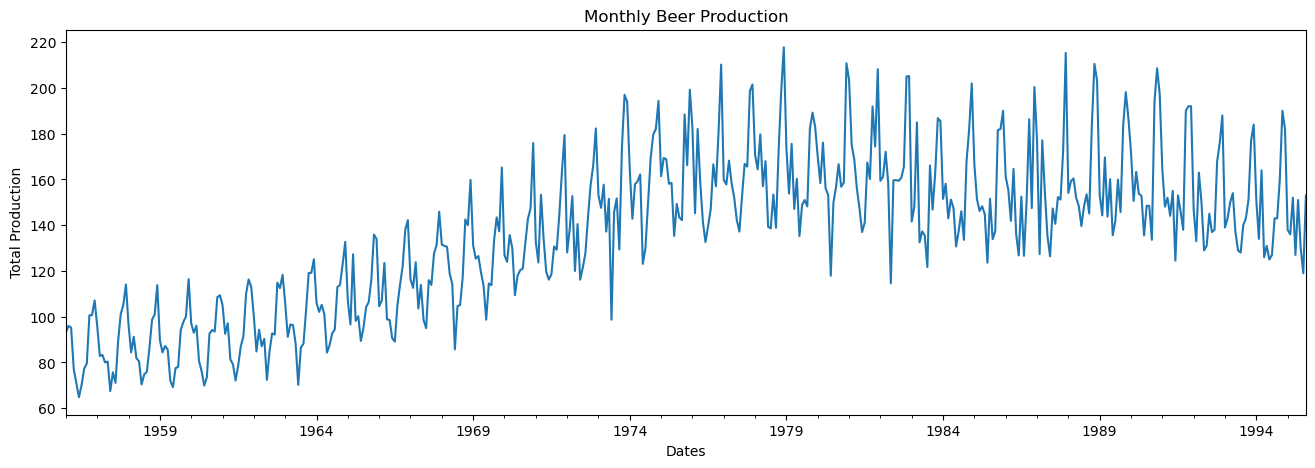

In [10]:
ax = df['Monthly beer production'].plot(figsize = (16,5), title = "Monthly Beer Production")
ax.set(xlabel='Dates', ylabel='Total Production');

#### training and testing data set definition

In [11]:
#The training data set ends 12 periods earlier than the original data set
train_data = df[:len(df)-12]

#The test data set starts when there are 12 periods left before the end of the original data set
test_data = df[len(df)-12:]

#### Data preprocessing with MinMaxScaler

In [12]:
#import library
from sklearn.preprocessing import MinMaxScaler

#definition of the normalization method
scaler = MinMaxScaler()

In [13]:
#scaler learns the parameters from the training data. These parameters are used to transform the data.
scaler.fit(train_data)

#the training data is scaled (e.g., standardized or normalized) using the parameters learned in the previous step.
scaled_train_data = scaler.transform(train_data)

#the test data is scaled (e.g., standardized or normalized) using the parameters learned in the previous step.
scaled_test_data = scaler.transform(test_data)

#### creation of the Time Series Generator object.

**from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator**. Here, the TimeseriesGenerator class of the 
tensorflow.keras.preprocessing.sequence module. **TimeseriesGenerator** is a TensorFlow utility for generating 
batches of time series data, where the input and output data are sampled uniformly over time.

In [14]:
#import libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [15]:
#input is the number of time steps that will be used as input to predict the next time step (12 prediction periods)
n_input = 12

#n_features is the number of features in the input data. In this case, there is only one feature.
n_features= 1

#create the TimeseriesGenerator instance
#The arguments are the input and output data (in this case, both are scaled_train_data)
#TimeseriesGenerator will generate batches of 12 consecutive time slots of scaled_train_data as input and the 
#13th time slot as output.
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, 
                                length=n_input, batch_size=1)

## LSTM model training

### Basic LSTM model

In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [18]:
#creation of the sequential model.
lstm_model = Sequential()

#adding an LSTM (Long Short-Term Memory) layer. With 50 neurons, ReLU (Rectified Linear Unit) activation function, 
#n_input = 12 prediction periods, n_features = only one feature
lstm_model.add(LSTM(50, activation='relu', input_shape=(n_input, n_features)))

#adding a dense layer to your model (results output)
lstm_model.add(Dense(1))

#model compilation. Optimizer = adam, loss='mse' (Mean Squared Error)
lstm_model.compile(optimizer='adam', loss='mse')

#printing the model summary
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
#model fit
lstm_model.fit(generator, epochs=20)

Epoch 1/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.0600
Epoch 2/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0142
Epoch 3/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0163
Epoch 4/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0123
Epoch 5/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0100
Epoch 6/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0085
Epoch 7/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0072
Epoch 8/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0071
Epoch 9/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0082
Epoch 10/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0074
Epoch 11/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0069
Epoch 12/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0060
Epoch 13/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0060
Epoch 14/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0066
Epoch 15/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - l

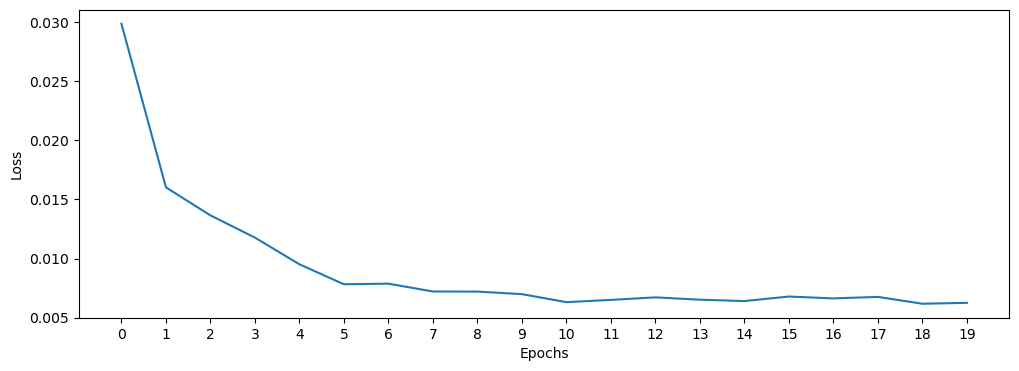

In [20]:
# extracting the loss history of the model after training.
losses_lstm = lstm_model.history.history['loss']

#creation of a new figure for history
plt.figure(figsize=(12,4))

#Labels for the x and y axis of the graph.
plt.xlabel("Epochs")
plt.ylabel("Loss")

#Defining x-axis mark locations and labels. np.arange(0,21,1) generates an array that goes from 0 to 20 with a step of 1.
plt.xticks(np.arange(0,21,1))

#graph of the loss as a function of the epochs.
plt.plot(range(len(losses_lstm)),losses_lstm);

## Prediction on test data

Next we are going to make a prediction for 12 months (12 predictions). To do this we are going to do the following:
- create an empty list for each of our 12 predictions
- create the batch that our model will predict
- save the prediction to our list
- add the prediction to the end of the batch to use it in the next prediction

In [22]:
# create an empty list for each of our 12 predictions
lstm_predictions_scaled = list()

#create the batch that our model will predict: 
#selecting the last n_input data points from the scaled training data set to form the first batch of data to be 
#fed to the LSTM model.
batch = scaled_train_data[-n_input:]

#adjusting the batch of data to have the shape required by the LSTM model, which is (number of samples, time steps,
#number of features).
current_batch = batch.reshape((1, n_input, n_features))

#save the prediction to our list:
#The for loop is iterating over each data point in the test data set. For each iteration, do the following:

for i in range(len(test_data)):   
    #use the LSTM model to predict the next data point based on the current batch of data.
    lstm_pred = lstm_model.predict(current_batch)[0]
    
    #adding the LSTM model prediction to the lstm_predictions_scaled list.
    lstm_predictions_scaled.append(lstm_pred) 
    
    #updating the current batch of data by removing the oldest data point and adding the new LSTM model prediction at the end.
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


As you know, we scale our data, so we have to invert it to see original predictions

In [23]:
#LSTM model predictions
lstm_predictions_scaled

[array([0.5090156], dtype=float32),
 array([0.59186506], dtype=float32),
 array([0.7073705], dtype=float32),
 array([0.7106221], dtype=float32),
 array([0.5582463], dtype=float32),
 array([0.5332929], dtype=float32),
 array([0.57525223], dtype=float32),
 array([0.43408027], dtype=float32),
 array([0.42884633], dtype=float32),
 array([0.40847448], dtype=float32),
 array([0.43251544], dtype=float32),
 array([0.4867627], dtype=float32)]

In [25]:
#downscaling the LSTM model predictions so that they are on the same scale as the original data
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [26]:
lstm_predictions

array([[142.67938982],
       [155.3553546 ],
       [173.0276895 ],
       [173.52517705],
       [150.21168612],
       [146.39381211],
       [152.81359195],
       [131.21428176],
       [130.41348841],
       [127.2965947 ],
       [130.97486268],
       [139.27469348]])

In [27]:
#adding the LSTM model predictions to the test data set.
test_data['LSTM_Predictions'] = lstm_predictions

In [28]:
test_data

,Monthly beer production,LSTM_Predictions
Month,,
1994-09-01,143.0,142.679390
1994-10-01,160.0,155.355355
1994-11-01,190.0,173.027690
1994-12-01,182.0,173.525177
1995-01-01,138.0,150.211686
1995-02-01,136.0,146.393812
1995-03-01,152.0,152.813592
1995-04-01,127.0,131.214282
1995-05-01,151.0,130.413488


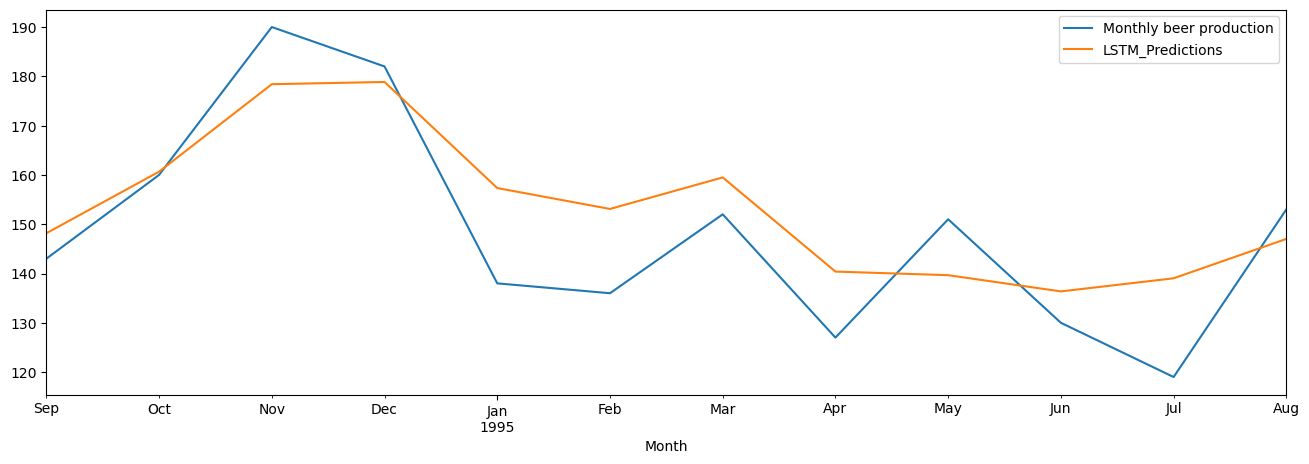

In [30]:
#actual monthly beer production and LSTM model predictions on the same graph.
test_data['Monthly beer production'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [29]:
#calculating the root mean square error (RMSE) between the actual monthly beer production and the LSTM model predictions.
lstm_rmse_error = rmse(test_data['Monthly beer production'], test_data["LSTM_Predictions"])

#calculating the mean square error (MSE) by squaring the RMSE.
lstm_mse_error = lstm_rmse_error**2

#calculating the average value of monthly beer production.
mean_value = df['Monthly beer production'].mean()

#the MSE, and RMSE and the mean value are printed.
print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 118.33586794456883
RMSE Error: 10.878229081269103
Mean: 136.3953781512605
